# Red neuronal perceptrón multicapa (PM)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
import statistics ##promedio listas
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from wordcloud import WordCloud # Import the wordcloud library
import tensorflow as tf
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
##from tensorflow.keras.layers import InputLayer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
import numpy as np
from time import time
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Maestria MAD/3 Semestre/Redes neuronales artificiales/Proyecto RNA/Proyecto/clasificacion_calidad_analisis.xlsx') #Shamir

## Eliminación de ruido

In [ ]:
Texto=data['Análisis']

In [ ]:

processed_text = []

url = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
menciones = '@[\w\-]+'
hashtag = '#[\w\-]+'
#caracteres_especiales = r'\W'
caracter_individual=r'\s+[a-zA-Z]\s+'
caracter_individual_inicio= r'\^[a-zA-Z]\s+'
varios_espacios= r'\s+'
prefijo_b = r'^b\s+'

for t in Texto:
    texto_procesado = t.lower()  #Convertir a minúsculas
    texto_procesado = re.sub(menciones, ' ', texto_procesado)
    texto_procesado = re.sub(hashtag, ' ', texto_procesado)
    texto_procesado = re.sub(url, ' ', texto_procesado)
    #texto_procesado = re.sub(caracteres_especiales, ' ', texto_procesado)
    texto_procesado = re.sub(caracter_individual, ' ', texto_procesado)
    texto_procesado = re.sub(caracter_individual_inicio, ' ', texto_procesado) 
    texto_procesado = re.sub(prefijo_b, '', texto_procesado)
    texto_procesado = re.sub(varios_espacios, ' ', texto_procesado, flags=re.I)
    texto_procesado= re.sub("á",'a',texto_procesado)
    texto_procesado= re.sub("é",'e',texto_procesado)
    texto_procesado= re.sub("í",'i',texto_procesado)
    texto_procesado= re.sub("ó",'o',texto_procesado)
    texto_procesado= re.sub("ú",'u',texto_procesado)
    texto_procesado= re.sub("ñ",'n',texto_procesado)
    texto_procesado= re.sub("'",'',texto_procesado)

    processed_text.append(texto_procesado)   #agregar a la lista de tweets procesados

## Eliminacion de stop words

In [ ]:
stop_words = stopwords.words('spanish')

In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

In [ ]:
data_words = remove_stopwords(processed_text)

In [ ]:
print(data_words[1])

['partir', 'septiembre', 'realizo', 'ajuste', 'parametrizacion', 'motivos', 'cancelacion', 'citas', 'ajuste', 'motivos', 'realizo', 'discriminacion', 'motivos', 'cancelacion', 'causa', 'paciente', 'motivos', 'cancelacion', 'causa', 'ello', 'partir', 'mes', 'octubre', 'datos', 'presentan', 'variacion', 'causa', 'paciente', 'total', 'citas', 'canceladas', 'motivos', 'paciente', 'mes', 'octubre', 'citas', 'principal', 'causa', 'cancelacion', 'servicio', 'consulta', 'especialista', 'citas', 'canceladas', 'cuales', 'cancelaron', 'motivos', 'personales', 'cancelaron', 'examenes', 'completos', 'cancelaron', 'condicion', 'clinica', 'hospitalizado', 'urgencias', 'procedimiento', 'citas', 'canceladas', 'cuales', 'cancelaron', 'motivos', 'personales', 'rehabilitacion', 'citas', 'canceladas', 'cuales', 'cancelaron', 'cruce', 'citas']


## Stem

In [ ]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    #tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in text:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


In [ ]:
stemmer = SnowballStemmer("spanish")
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in data_words:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list


## Word cloud

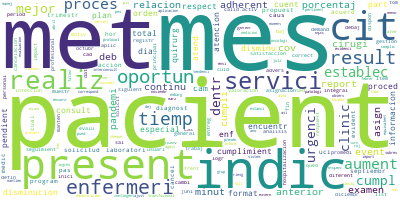

In [ ]:

long_string = ' '.join(([str(data) for data in totalvocab_stemmed])) 

# Create a WordCloud object
wordcloud = WordCloud(background_color="white",collocations=False)

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

## TFIDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(Texto) #fit the vectorizer to synopses

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  % sorted(inconsistent)


CPU times: user 2.33 s, sys: 2.26 ms, total: 2.33 s
Wall time: 2.35 s


In [ ]:
tdidf=tfidf_matrix.toarray()

In [ ]:
data['STOPW']=data_words
data['TDIDF']=[x for x in tdidf]

In [ ]:
data.head()

,proceso,Indicador,Código Indicador,Unidad de medida,Periodicidad,Finalidad,Variables,Análisis,Semaforo,Calificación,Periodo medido,Calificacion_analisis,STOPW,TDIDF
0,Laboratorio Clínico y Servicio Transfusional,Oportunidad en la entrega de resultados de lab...,LAB0-02-03-3,Horas,Mensual,Minimizar,Sumatoria del tiempo transcurrido entre la sol...,Durante el mes de noviembre disminuyeron los p...,seguridad,230.36,Noviembre 2020,1.0,"[mes, noviembre, disminuyeron, pacientes, tamb...","[0.13801686325594817, 0.0, 0.10677059566316846..."
1,ATENCIÓN AMBULATORIA,Cancelación de citas causa paciente ***,AMB0-04-02-1,Porcentaje,Mensual,Minimizar,Número de citas canceladas consulta medicina e...,A partir del 27 de Septiembre se realizó el aj...,seguridad,313.45,Octubre 2019,1.0,"[partir, septiembre, realizo, ajuste, parametr...","[0.0507406067031608, 0.01837674564879671, 0.05..."
2,Clínicas Médicas,Tiempo entre alta médica y el alta administrat...,CME0-04-03-3,Horas,Mensual,Minimizar,Sumatoria del tiempo transcurrido entre la emi...,El indicador se registra dentro de las metas e...,seguridad,98.26,Agosto 2019,2.0,"[indicador, registra, dentro, metas, estableci...","[0.10975092543758022, 0.15899414473188214, 0.0..."
3,Referencia y Contrarreferencia,Tiempo medio de remisión electiva entre sedes,REF0-02-04-0,Horas,Mensual,Minimizar,Sumatoria de los tiempos de traslados electivo...,Promedio de traslado electivo 27:33:38 \n,alerta,87.08,Octubre 2021,2.0,"[promedio, traslado, electivo]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Laboratorio Clínico y Servicio Transfusional,Oportunidad en la respuesta del servicio trans...,LAB0-03-13-3,Minutos,Mensual,Minimizar,Sumatoria de minutos desde la solicitud de hem...,En el mes de noviembre no se presentaron códig...,seguridad,100.00,Noviembre 2020,2.0,"[mes, noviembre, presentaron, codigos, rojos, ...","[0.09303716084425899, 0.0, 0.14394810674301323..."


# Busqueda de parametros con Gridsearch

https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/

In [ ]:
dataf=data[['TDIDF','Calificacion_analisis']]

In [ ]:
train_labe = to_categorical(dataf['Calificacion_analisis'])

In [ ]:
##dividir test entre entrenamiento, prueba, test
train_data=np.array([np.array(val) for val in dataf['TDIDF'][:350]])
test_data =np.array([np.array(val) for val in dataf['TDIDF'][350:426]])
val_data =np.array([np.array(val) for val in dataf['TDIDF'][426:]])

#train_labels = np.array([np.array(val) for val in dataf[['categories_-1.0','categories_0.0',	'categories_1.0']][:350]])
#test_labels = np.array([np.array(val) for val in dataf[['categories_-1.0','categories_0.0',	'categories_1.0']][350:]])
test_labels = np.array([np.array(val) for val in train_labe[350:426]])
train_labels = np.array([np.array(val) for val in train_labe[:350]])
val_labels = np.array([np.array(val) for val in train_labe[426:]])

## Opción **1**

In [ ]:
def create_network(optimizer='rmsprop',neurons1=16, neurons2=16,epochs=50, batch_size=5,
                     learn_rate=0.1,  dropout_rate=0.0, activation1='relu',activation2='relu'):
    model = Sequential()
    model.add(Dense(neurons1,
                    input_shape=(197,),
                    activation=activation1,
                    kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(neurons2, activation=activation2))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss = 'categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])           
    
    #model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    #            optimizer=optimizer,
    #            metrics=['accuracy'])
    return model

In [ ]:
# Implementación de la API del clasificador scikit-learn para Keras.
neural_network = KerasClassifier(build_fn=create_network, verbose=1) ### para busqueda en grilla clasificacion

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
kfold = KFold(n_splits=4, random_state=None)

grid_param = { 
    'batch_size': [16,24,50], 
    'epochs': [10,20,30,50], 
    'neurons1': [100,150,200],  
    'neurons2': [28,40,70],
    'activation1': ['relu','sigmoid'],
    'activation2' : ['relu','sigmoid'],
    'learn_rate' : [0.1,0.01],
    'dropout_rate' : [0.0,0.1,0.2] 
}

scoring = ['accuracy'] #, 'recall'

tiempo_inicial = time() 

gs = GridSearchCV(neural_network,
                  param_grid=grid_param,
                  cv=kfold,
                  n_jobs=-1,
                  verbose=2)
gs.fit(train_data, train_labels)
tiempo_final = time() 

results = gs.cv_results_
print("\n Mejor desempeño: ", gs.best_score_)
print("\n Mejores hiper parámetros:\n",gs.best_params_)

tiempo_ejecucion = tiempo_final - tiempo_inicial
print('\nEl tiempo, en min, de ejecucion fue:%s'% str(tiempo_ejecucion/60))

df = pd.DataFrame(results)
df.head()

Fitting 4 folds for each of 2592 candidates, totalling 10368 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/50
7/7 [==============================] - 1s 3ms/step - loss: 2.6065 - accuracy: 0.3657
Epoch 2/50
7/7 [==============================] - 0s 2ms/step - loss: 2.2236 - accuracy: 0.3943
Epoch 3/50
7/7 [==============================] - 0s 3ms/step - loss: 2.0042 - accuracy: 0.4143
Epoch 4/50
7/7 [==============================] - 0s 3ms/step - loss: 1.8301 - accuracy: 0.5286
Epoch 5/50
7/7 [==============================] - 0s 3ms/step - loss: 1.6816 - accuracy: 0.5657
Epoch 6/50
7/7 [==============================] - 0s 2ms/step - loss: 1.5562 - accuracy: 0.5657
Epoch 7/50
7/7 [==============================] - 0s 3ms/step - loss: 1.4399 - accuracy: 0.5857
Epoch 8/50
7/7 [==============================] - 0s 3ms/step - loss: 1.3421 - accuracy: 0.5971
Epoch 9/50
7/7 [==============================] - 0s 3ms/step - loss: 1.2600 - accuracy: 0.6029
Epoch 10/50
7/7 [==============================] - 0s 2ms/step - loss: 1.1837 - accuracy: 0.6171
Epoch 11/50
7/7 [======================

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation1,param_activation2,param_batch_size,param_dropout_rate,param_epochs,param_learn_rate,param_neurons1,param_neurons2,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,1.691461,0.192959,0.235231,0.046680,relu,relu,16,0.0,10,0.1,100,28,"{'activation1': 'relu', 'activation2': 'relu',...",0.590909,0.477273,0.482759,0.666667,0.554402,0.079085,631
1,1.421000,0.114671,0.227793,0.043135,relu,relu,16,0.0,10,0.1,100,40,"{'activation1': 'relu', 'activation2': 'relu',...",0.568182,0.545455,0.482759,0.643678,0.560018,0.057547,505
2,1.505534,0.025233,0.221708,0.037361,relu,relu,16,0.0,10,0.1,100,70,"{'activation1': 'relu', 'activation2': 'relu',...",0.556818,0.500000,0.505747,0.712644,0.568802,0.085941,309
3,1.366768,0.115396,0.236127,0.012855,relu,relu,16,0.0,10,0.1,150,28,"{'activation1': 'relu', 'activation2': 'relu',...",0.545455,0.488636,0.482759,0.689655,0.551626,0.083367,660
4,1.669906,0.171772,0.206939,0.045873,relu,relu,16,0.0,10,0.1,150,40,"{'activation1': 'relu', 'activation2': 'relu',...",0.329545,0.522727,0.413793,0.724138,0.497551,0.147662,1180


In [ ]:
df.to_excel(r'/content/drive/MyDrive/Maestria MAD/3 Semestre/Redes neuronales artificiales/Proyecto RNA/Proyecto/ResultsGXBnan.xlsx')
#df.to_excel(r'ResultsGXB.xlsx')
df.shape

(2592, 20)

In [ ]:
df=pd.read_excel(r'/content/drive/MyDrive/Maestria MAD/3 Semestre/Redes neuronales artificiales/Proyecto RNA/Proyecto/ResultsGXBnan.xlsx')

In [ ]:
import json ## convierte el archivo generado como string en diccionario
index = 1148
#index = df['mean_test_precision'].argmax()
params = df.loc[index, 'params']
json_acceptable_string =params.replace("'", "\"")
d = json.loads(json_acceptable_string)

In [ ]:
d

{'activation1': 'relu',
 'activation2': 'sigmoid',
 'batch_size': 50,
 'dropout_rate': 0.0,
 'epochs': 50,
 'learn_rate': 0.01,
 'neurons1': 150,
 'neurons2': 70}

In [ ]:
clfAlg = create_network(**d)

history = clfAlg.fit(train_data, train_labels,epochs=50,verbose=0)

print(index)
print(clfAlg)

1148


In [ ]:
# Obteniendo prediciones
predict_prob = clfAlg.predict(test_data)
predict_classes=np.argmax(predict_prob,axis=1)
y_classes = [np.argmax(y, axis=None, out=None) for y in test_labels]

print("Etiquetas reales\n",y_classes)
print("\nEtiquetas predichas\n",predict_classes)
print("\nAcerto el modelo? \n",['Si' if e==1 else 'No' for e in list(predict_classes==y_classes)])

Etiquetas reales
 [2, 2, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 0, 0, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2]

Etiquetas predichas
 [2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 0 2 2 1 2 0 0 2 0 0 2 2 2 2 2 0 0 0 2 2 2
 2 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 2 2]

Acerto el modelo? 
 ['Si', 'Si', 'Si', 'No', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'No', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si']


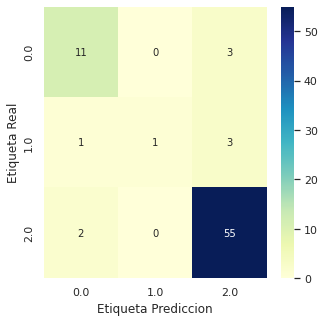

In [ ]:
data = {'y_Actual':    y_classes,
        'y_Predicted': predict_classes
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted']).astype(float)
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Etiqueta Real'], colnames=['Etiqueta Prediccion'])

sn.set(rc = {'figure.figsize':(5,5)})
sn.heatmap(confusion_matrix, annot=True,annot_kws={"size": 10},fmt="d", cmap="YlGnBu")
plt.show()

In [ ]:
results = clfAlg.evaluate(test_data, test_labels)
results

3/3 [==============================] - 0s 5ms/step - loss: 0.4276 - accuracy: 0.8816


[0.427609384059906, 0.8815789222717285]

In [ ]:
results_val = clfAlg.evaluate(val_data, val_labels)
results_val

3/3 [==============================] - 0s 4ms/step - loss: 0.5106 - accuracy: 0.8400


[0.5105806589126587, 0.8399999737739563]

Acertividad etiquetas

In [ ]:
filtrada1 = [] # la lista filtra los que son clase=1
for i in range(len(predict_classes)):
    if predict_classes[i] == 1:
        filtrada1.append(i)

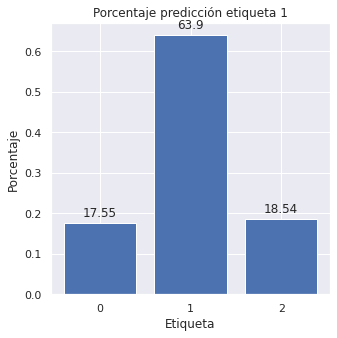

In [ ]:
eje_x=['0','1','2']

# Creating histogram
fig, ax = plt.subplots(1, 1)
ax.bar(eje_x, list((statistics.mean(predict_prob[filtrada1][:,0]),statistics.mean(predict_prob[filtrada1][:,1]),statistics.mean(predict_prob[filtrada1][:,2]))))
  
# Set title
ax.set_title("Porcentaje predicción etiqueta 1")
  
# adding labels
ax.set_xlabel('Etiqueta')
ax.set_ylabel('Porcentaje')
  
# Make some labels.
rects = ax.patches
labels = [round(i*100,2) for i in 
    list((statistics.mean(predict_prob[filtrada1][:,0]),statistics.mean(predict_prob[filtrada1][:,1]),statistics.mean(predict_prob[filtrada1][:,2])))
]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')
  
# Show plot
plt.show()

In [ ]:
filtrada0 = [] # la lista filtra los que son clase=1
for i in range(len(predict_classes)):
    if predict_classes[i] == 0:
        filtrada0.append(i)

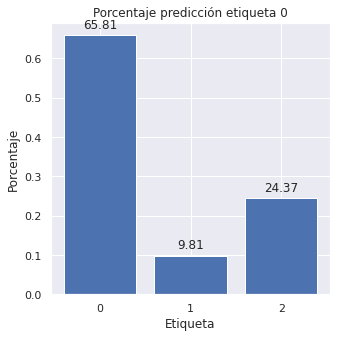

In [ ]:
# Creating histogram
fig, ax = plt.subplots(1, 1)
ax.bar(eje_x, list((statistics.mean(predict_prob[filtrada0][:,0]),statistics.mean(predict_prob[filtrada0][:,1]),statistics.mean(predict_prob[filtrada0][:,2]))))
  
# Set title
ax.set_title("Porcentaje predicción etiqueta 0")
  
# adding labels
ax.set_xlabel('Etiqueta')
ax.set_ylabel('Porcentaje')
  
# Make some labels.
rects = ax.patches
labels = [round(i*100,2) for i in 
    list((statistics.mean(predict_prob[filtrada0][:,0]),statistics.mean(predict_prob[filtrada0][:,1]),statistics.mean(predict_prob[filtrada0][:,2])))
]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')
  
# Show plot
plt.show()

In [ ]:
filtrada2 = [] # la lista filtra los que son clase=1
for i in range(len(predict_classes)):
    if predict_classes[i] == 2:
        filtrada2.append(i)

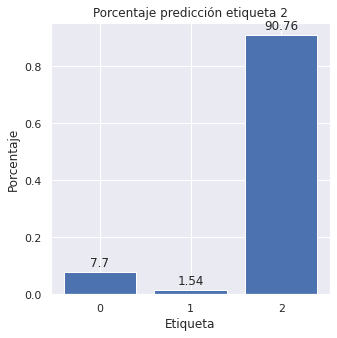

In [ ]:
# Creating histogram
fig, ax = plt.subplots(1, 1)
ax.bar(eje_x, list((statistics.mean(predict_prob[filtrada2][:,0]),statistics.mean(predict_prob[filtrada2][:,1]),statistics.mean(predict_prob[filtrada2][:,2]))))
  
# Set title
ax.set_title("Porcentaje predicción etiqueta 2")
  
# adding labels
ax.set_xlabel('Etiqueta')
ax.set_ylabel('Porcentaje')
  
# Make some labels.
rects = ax.patches
labels = [round(i*100,2) for i in 
    list((statistics.mean(predict_prob[filtrada2][:,0]),statistics.mean(predict_prob[filtrada2][:,1]),statistics.mean(predict_prob[filtrada2][:,2])))
]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')
  
# Show plot
plt.show()

## Opción 2

Probando modelo con 3 capas ocultas

In [ ]:
def create_network2(optimizer='rmsprop',neurons1=150,neurons2=70,neurons3=16, epochs=50, batch_size=50,
                     learn_rate=0.01,  dropout_rate=0.01, activation1='relu', activation2='sigmoid',activation3='relu'):
    model = Sequential()
    model.add(Dense(neurons1,
                    input_shape=(197,),
                    activation=activation1,
                    kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(neurons2, activation=activation2))
    model.add(Dense(neurons3, activation=activation3))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss = 'categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])           
    
    #model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    #            optimizer=optimizer,
    #            metrics=['accuracy'])
    return model

In [ ]:
# Implementación de la API del clasificador scikit-learn para Keras.
neural_network2 = KerasClassifier(build_fn=create_network2, verbose=1) ### para busqueda en grilla clasificacion

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
kfold = KFold(n_splits=4, random_state=None)

grid_param = {
    'neurons3': [6,8,10,14,28,40,50,80],
    'activation3' : ['relu','sigmoid','tanh'],
    'dropout_rate' : [0.0,0.1,0.2] 

    
}


scoring = ['accuracy'] #, 'recall'

#kfold = KFold(n_splits=4, random_state=None)

tiempo_inicial = time() 

gs1 = GridSearchCV(neural_network2,
                  param_grid=grid_param,
                  cv=kfold,
                  n_jobs=-1,
                  verbose=2)
gs1.fit(train_data, train_labels)
tiempo_final = time() 


results = gs1.cv_results_
print("\n Mejor desempeño: ", gs1.best_score_)
print("\n Mejores hiper parámetros:\n",gs1.best_params_)

tiempo_ejecucion = tiempo_final - tiempo_inicial
print('\nEl tiempo, en min, de ejecucion fue:%s'% str(tiempo_ejecucion/60))


df = pd.DataFrame(results)
df.head()

Fitting 4 folds for each of 72 candidates, totalling 288 fits
11/11 [==============================] - 1s 2ms/step - loss: 2.4991 - accuracy: 0.3514

 Mejor desempeño:  0.463035523891449

 Mejores hiper parámetros:
 {'activation3': 'tanh', 'dropout_rate': 0.2, 'neurons3': 40}

El tiempo, en min, de ejecucion fue:3.657253114382426


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation3,param_dropout_rate,param_neurons3,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,1.212724,0.115144,0.289744,0.015498,relu,0.0,6,"{'activation3': 'relu', 'dropout_rate': 0.0, '...",0.500000,0.340909,0.390805,0.229885,0.365400,0.097117,11
1,1.570352,0.439684,0.394546,0.122589,relu,0.0,8,"{'activation3': 'relu', 'dropout_rate': 0.0, '...",0.238636,0.340909,0.310345,0.724138,0.403507,0.188802,4
2,1.388326,0.265734,0.274695,0.009008,relu,0.0,10,"{'activation3': 'relu', 'dropout_rate': 0.0, '...",0.238636,0.306818,0.310345,0.724138,0.394984,0.192174,5
3,1.133485,0.018608,0.276029,0.005461,relu,0.0,14,"{'activation3': 'relu', 'dropout_rate': 0.0, '...",0.238636,0.306818,0.448276,0.045977,0.259927,0.144829,33
4,1.290201,0.164534,0.271751,0.006252,relu,0.0,28,"{'activation3': 'relu', 'dropout_rate': 0.0, '...",0.261364,0.477273,0.310345,0.045977,0.273740,0.153944,24


In [ ]:
df.to_excel(r'/content/drive/MyDrive/Maestria MAD/3 Semestre/Redes neuronales artificiales/Proyecto RNA/Proyecto/ResultsGXB2.xlsx')
#df.to_excel(r'ResultsGXB.xlsx')
df.shape

(72, 15)

In [ ]:
d2={'activation3': 'tanh', 'dropout_rate': 0.2, 'neurons3': 40}

In [ ]:
clfAlg2 = create_network2(**d2)

history2 = clfAlg2.fit(train_data, train_labels,epochs=50,verbose=0)

print(index)
print(clfAlg)

1148


In [ ]:
Mod2 = create_network2(**d2)

history2 = Mod2.fit(train_data, train_labels,epochs=50,verbose=0)

print(index)
print(Mod2)

1148


In [ ]:
# Obteniendo prediciones
predict_prob2 = Mod2.predict(test_data)
predict_classes2=np.argmax(predict_prob2,axis=1)
y_classes2 = [np.argmax(y, axis=None, out=None) for y in test_labels]

print("Etiquetas reales\n",y_classes2)
print("\nEtiquetas predichas\n",predict_classes2)
print("\nAcerto el modelo? \n",['Si' if e==1 else 'No' for e in list(predict_classes2==y_classes2)])

Etiquetas reales
 [2, 2, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 0, 0, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2]

Etiquetas predichas
 [2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 1 2 2 0 2 0 0 2 2 2 2 2 0 2 2 2 2 2
 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 2 2]

Acerto el modelo? 
 ['Si', 'Si', 'Si', 'No', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'No', 'Si', 'Si', 'Si', 'No', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'No', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si']


Acertividad de las etiquetas

In [ ]:
filtrada1 = [] # la lista filtra los que son clase=1
for i in range(len(predict_classes2)):
    if predict_classes2[i] == 1:
        filtrada1.append(i)


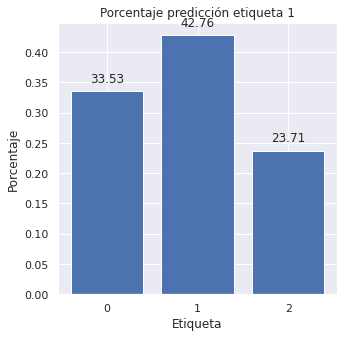

In [ ]:
# Creating histogram
fig, ax = plt.subplots(1, 1)
ax.bar(eje_x, list((statistics.mean(predict_prob2[filtrada1][:,0]),statistics.mean(predict_prob2[filtrada1][:,1]),statistics.mean(predict_prob2[filtrada1][:,2]))))
  
# Set title
ax.set_title("Porcentaje predicción etiqueta 1")
  
# adding labels
ax.set_xlabel('Etiqueta')
ax.set_ylabel('Porcentaje')
  
# Make some labels.
rects = ax.patches
labels = [round(i*100,2) for i in 
    list((statistics.mean(predict_prob2[filtrada1][:,0]),statistics.mean(predict_prob2[filtrada1][:,1]),statistics.mean(predict_prob2[filtrada1][:,2])))
]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')
  
# Show plot
plt.show()

In [ ]:
filtrada0 = [] # la lista filtra los que son clase=1
for i in range(len(predict_classes2)):
    if predict_classes2[i] == 0:
        filtrada0.append(i)


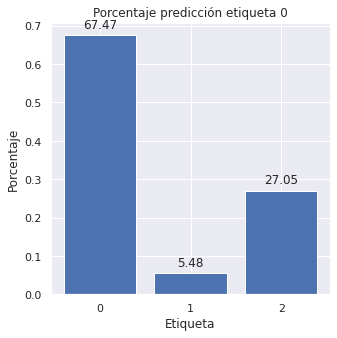

In [ ]:
# Creating histogram
fig, ax = plt.subplots(1, 1)
ax.bar(eje_x, list((statistics.mean(predict_prob2[filtrada0][:,0]),statistics.mean(predict_prob2[filtrada0][:,1]),statistics.mean(predict_prob2[filtrada0][:,2]))))
  
# Set title
ax.set_title("Porcentaje predicción etiqueta 0")
  
# adding labels
ax.set_xlabel('Etiqueta')
ax.set_ylabel('Porcentaje')
  
# Make some labels.
rects = ax.patches
labels = [round(i*100,2) for i in 
    list((statistics.mean(predict_prob2[filtrada0][:,0]),statistics.mean(predict_prob2[filtrada0][:,1]),statistics.mean(predict_prob2[filtrada0][:,2])))
]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')
  
# Show plot
plt.show()
 

In [ ]:
filtrada2 = [] # la lista filtra los que son clase=1
for i in range(len(predict_classes2)):
    if predict_classes2[i] == 2:
        filtrada2.append(i)


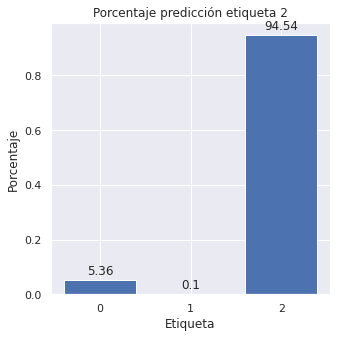

In [ ]:
# Creating histogram
fig, ax = plt.subplots(1, 1)
ax.bar(eje_x, list((statistics.mean(predict_prob2[filtrada2][:,0]),statistics.mean(predict_prob2[filtrada2][:,1]),statistics.mean(predict_prob2[filtrada2][:,2]))))
  
# Set title
ax.set_title("Porcentaje predicción etiqueta 2")
  
# adding labels
ax.set_xlabel('Etiqueta')
ax.set_ylabel('Porcentaje')
  
# Make some labels.
rects = ax.patches
labels = [round(i*100,2) for i in 
    list((statistics.mean(predict_prob2[filtrada2][:,0]),statistics.mean(predict_prob2[filtrada2][:,1]),statistics.mean(predict_prob2[filtrada2][:,2])))
]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')
  
# Show plot
plt.show()

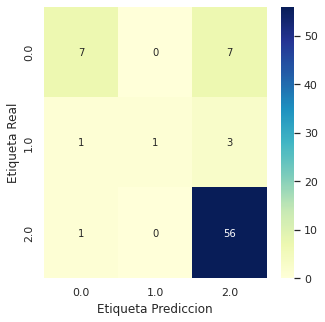

In [ ]:
data = {'y_Actual':    y_classes2,
        'y_Predicted': predict_classes2
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted']).astype(float)
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Etiqueta Real'], colnames=['Etiqueta Prediccion'])

sn.set(rc = {'figure.figsize':(5,5)})
sn.heatmap(confusion_matrix, annot=True,annot_kws={"size": 10},fmt="d", cmap="YlGnBu")
plt.show()

In [ ]:
results2 = Mod2.evaluate(test_data, test_labels)
results2

3/3 [==============================] - 0s 6ms/step - loss: 0.5858 - accuracy: 0.8421


[0.585822343826294, 0.8421052694320679]

In [ ]:
results_val2 = Mod2.evaluate(val_data, val_labels)
results_val2

3/3 [==============================] - 0s 7ms/step - loss: 0.6371 - accuracy: 0.8267


[0.6371273398399353, 0.8266666531562805]

## Opción 3
una sola capa

In [ ]:
def create_network3(optimizer='rmsprop',neurons1=16,epochs=50, batch_size=5,
                     learn_rate=0.1,  dropout_rate=0.0, activation1='relu'):
    model = Sequential()
    model.add(Dense(neurons1,
                    input_shape=(197,),
                    activation=activation1,
                    kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss = 'categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])           
    
    #model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    #            optimizer=optimizer,
    #            metrics=['accuracy'])
    return model

In [ ]:
# Implementación de la API del clasificador scikit-learn para Keras.
neural_network3 = KerasClassifier(build_fn=create_network3, verbose=1) ### para busqueda en grilla clasificacion

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
kfold = KFold(n_splits=4, random_state=None)

grid_param = {
    'neurons1': [100,200,300,500,800,1000],
    'activation1' : ['relu','sigmoid','tanh'],
    'dropout_rate' : [0.0,0.1], 
    'learn_rate': [0.0,0.15],
    'dropout_rate':[0.0,0.05]    
}


scoring = ['accuracy'] #, 'recall'

#kfold = KFold(n_splits=4, random_state=None)

tiempo_inicial = time() 

gs3 = GridSearchCV(neural_network3,
                  param_grid=grid_param,
                  cv=kfold,
                  n_jobs=-1,
                  verbose=2)
gs3.fit(train_data, train_labels)
tiempo_final = time() 


results3 = gs3.cv_results_
print("\n Mejor desempeño: ", gs3.best_score_)
print("\n Mejores hiper parámetros:\n",gs3.best_params_)

tiempo_ejecucion = tiempo_final - tiempo_inicial
print('\nEl tiempo, en min, de ejecucion fue:%s'% str(tiempo_ejecucion/60))


df = pd.DataFrame(results3)
df.head()

Fitting 4 folds for each of 72 candidates, totalling 288 fits
11/11 [==============================] - 1s 6ms/step - loss: 3.3900 - accuracy: 0.4714

 Mejor desempeño:  0.48837513476610184

 Mejores hiper parámetros:
 {'activation1': 'tanh', 'dropout_rate': 0.0, 'learn_rate': 0.15, 'neurons1': 1000}

El tiempo, en min, de ejecucion fue:2.997545313835144


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation1,param_dropout_rate,param_learn_rate,param_neurons1,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,1.564954,0.270567,0.550631,0.117126,relu,0.0,0.0,100,"{'activation1': 'relu', 'dropout_rate': 0.0, '...",0.284091,0.397727,0.344828,0.045977,0.268156,0.134429,59
1,1.411756,0.155646,0.402724,0.076282,relu,0.0,0.0,200,"{'activation1': 'relu', 'dropout_rate': 0.0, '...",0.352273,0.534091,0.448276,0.114943,0.362396,0.156677,28
2,0.848486,0.016580,0.268269,0.007299,relu,0.0,0.0,300,"{'activation1': 'relu', 'dropout_rate': 0.0, '...",0.238636,0.488636,0.402299,0.091954,0.305381,0.152464,51
3,0.876026,0.017333,0.263603,0.002324,relu,0.0,0.0,500,"{'activation1': 'relu', 'dropout_rate': 0.0, '...",0.227273,0.443182,0.505747,0.655172,0.457844,0.153795,5
4,0.884752,0.009258,0.276340,0.012348,relu,0.0,0.0,800,"{'activation1': 'relu', 'dropout_rate': 0.0, '...",0.579545,0.477273,0.459770,0.402299,0.479722,0.063959,2


In [ ]:
b_hp3={'activation1': 'tanh',
 'dropout_rate': 0.0,
 'learn_rate': 0.15,
 'neurons1': 1000}

In [ ]:
Mod3 = create_network3(**b_hp3)

history3 = Mod3.fit(train_data, train_labels,epochs=50,verbose=0)

print(Mod3)

In [ ]:
# Obteniendo prediciones
predict_prob3 = Mod3.predict(test_data)
predict_classes3=np.argmax(predict_prob3,axis=1)
y_classes3 = [np.argmax(y, axis=None, out=None) for y in test_labels]

print("Etiquetas reales\n",y_classes3)
print("\nEtiquetas predichas\n",predict_classes3)
print("\nAcerto el modelo? \n",['Si' if e==1 else 'No' for e in list(predict_classes3==y_classes3)])

Etiquetas reales
 [2, 2, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 0, 0, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2]

Etiquetas predichas
 [2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]

Acerto el modelo? 
 ['Si', 'Si', 'Si', 'No', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'No', 'Si', 'No', 'Si', 'No', 'Si', 'Si', 'No', 'No', 'Si', 'Si', 'Si', 'No', 'Si', 'No', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'No', 'Si', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'Si']


In [ ]:
results3 = Mod3.evaluate(test_data, test_labels)
print(results3)
results_val3 = Mod3.evaluate(val_data, val_labels)
print(results_val3)

3/3 [==============================] - 0s 6ms/step - loss: 0.6372 - accuracy: 0.7632
[0.6371776461601257, 0.7631579041481018]
3/3 [==============================] - 0s 5ms/step - loss: 0.7093 - accuracy: 0.8133
[0.7092781662940979, 0.8133333325386047]


Acertividad

In [ ]:
filtrada2 = [] # la lista filtra los que son clase=1
for i in range(len(predict_classes3)):
    if predict_classes3[i] == 2:
        filtrada2.append(i)

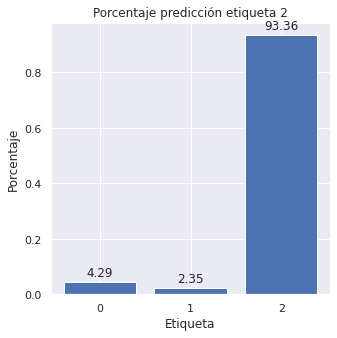

In [ ]:
# Creating histogram
fig, ax = plt.subplots(1, 1)
ax.bar(eje_x, list((statistics.mean(predict_prob3[filtrada2][:,0]),statistics.mean(predict_prob3[filtrada2][:,1]),statistics.mean(predict_prob3[filtrada2][:,2]))))
  
# Set title
ax.set_title("Porcentaje predicción etiqueta 2")
  
# adding labels
ax.set_xlabel('Etiqueta')
ax.set_ylabel('Porcentaje')
  
# Make some labels.
rects = ax.patches
labels = [round(i*100,2) for i in 
    list((statistics.mean(predict_prob3[filtrada2][:,0]),statistics.mean(predict_prob3[filtrada2][:,1]),statistics.mean(predict_prob3[filtrada2][:,2])))
]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')
  
# Show plot
plt.show()

In [ ]:
filtrada0 = [] # la lista filtra los que son clase=1
for i in range(len(predict_classes3)):
    if predict_classes3[i] == 0:
        filtrada0.append(i)

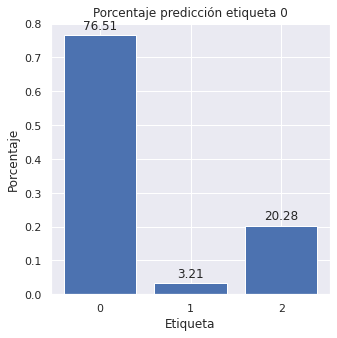

In [ ]:
# Creating histogram
fig, ax = plt.subplots(1, 1)
ax.bar(eje_x, list((statistics.mean(predict_prob3[filtrada0][:,0]),statistics.mean(predict_prob3[filtrada0][:,1]),statistics.mean(predict_prob3[filtrada0][:,2]))))
  
# Set title
ax.set_title("Porcentaje predicción etiqueta 0")
  
# adding labels
ax.set_xlabel('Etiqueta')
ax.set_ylabel('Porcentaje')
  
# Make some labels.
rects = ax.patches
labels = [round(i*100,2) for i in 
    list((statistics.mean(predict_prob3[filtrada0][:,0]),statistics.mean(predict_prob3[filtrada0][:,1]),statistics.mean(predict_prob3[filtrada0][:,2])))
]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')
  
# Show plot
plt.show()

In [ ]:
filtrada1 = [] # la lista filtra los que son clase=1
for i in range(len(predict_classes3)):
    if predict_classes3[i] == 1:
        filtrada1.append(i)

El modelo con 1 capa tiene peor metrica de accuracy adicional no realiza predicciones para la etiqueta 1

## Opcion 4

Probando con diferentes batch y epochs

In [ ]:
kfold = KFold(n_splits=4, random_state=None)

grid_param = { 
    'batch_size': [50,60,70,80,90,100], 
    'epochs': [50,55,60,65,70,75,80,85,90,95,100], 
    'neurons1': [100],  
    'neurons2': [70],
    'activation1': ['relu'],
    'activation2' : ['sigmoid'],
    'learn_rate' : [0.01],
    'dropout_rate' : [0.0] 
}

scoring = ['accuracy'] #, 'recall'

tiempo_inicial = time() 

gs = GridSearchCV(neural_network,
                  param_grid=grid_param,
                  cv=kfold,
                  n_jobs=-1,
                  verbose=2)
gs.fit(train_data, train_labels)
tiempo_final = time() 

results = gs.cv_results_
print("\n Mejor desempeño: ", gs.best_score_)
print("\n Mejores hiper parámetros:\n",gs.best_params_)

tiempo_ejecucion = tiempo_final - tiempo_inicial
print('\nEl tiempo, en min, de ejecucion fue:%s'% str(tiempo_ejecucion/60))

df = pd.DataFrame(results)
df.head()

Fitting 4 folds for each of 66 candidates, totalling 264 fits
Epoch 1/75
7/7 [==============================] - 1s 3ms/step - loss: 2.2401 - accuracy: 0.3943
Epoch 2/75
7/7 [==============================] - 0s 2ms/step - loss: 1.9967 - accuracy: 0.4771
Epoch 3/75
7/7 [==============================] - 0s 3ms/step - loss: 1.8405 - accuracy: 0.4314
Epoch 4/75
7/7 [==============================] - 0s 3ms/step - loss: 1.7066 - accuracy: 0.4829
Epoch 5/75
7/7 [==============================] - 0s 2ms/step - loss: 1.5900 - accuracy: 0.6057
Epoch 6/75
7/7 [==============================] - 0s 2ms/step - loss: 1.4897 - accuracy: 0.5171
Epoch 7/75
7/7 [==============================] - 0s 2ms/step - loss: 1.3972 - accuracy: 0.5714
Epoch 8/75
7/7 [==============================] - 0s 2ms/step - loss: 1.3168 - accuracy: 0.6057
Epoch 9/75
7/7 [==============================] - 0s 3ms/step - loss: 1.2452 - accuracy: 0.6057
Epoch 10/75
7/7 [==============================] - 0s 3ms/step - loss: 1.1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation1,param_activation2,param_batch_size,param_dropout_rate,param_epochs,param_learn_rate,param_neurons1,param_neurons2,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,2.036175,0.094540,0.265987,0.020728,relu,sigmoid,50,0.0,50,0.01,100,70,"{'activation1': 'relu', 'activation2': 'sigmoi...",0.545455,0.465909,0.471264,0.724138,0.551691,0.104408,61
1,1.992983,0.134217,0.251512,0.017234,relu,sigmoid,50,0.0,55,0.01,100,70,"{'activation1': 'relu', 'activation2': 'sigmoi...",0.590909,0.488636,0.482759,0.781609,0.585978,0.120857,10
2,2.107173,0.109136,0.236112,0.023151,relu,sigmoid,50,0.0,60,0.01,100,70,"{'activation1': 'relu', 'activation2': 'sigmoi...",0.545455,0.522727,0.436782,0.781609,0.571643,0.127820,41
3,2.085894,0.135954,0.287331,0.038391,relu,sigmoid,50,0.0,65,0.01,100,70,"{'activation1': 'relu', 'activation2': 'sigmoi...",0.556818,0.522727,0.448276,0.735632,0.565863,0.105583,49
4,2.265399,0.239859,0.285105,0.016517,relu,sigmoid,50,0.0,70,0.01,100,70,"{'activation1': 'relu', 'activation2': 'sigmoi...",0.602273,0.545455,0.448276,0.724138,0.580035,0.099770,26


In [ ]:
b_hp=gs.best_params_;b_hp

{'activation1': 'relu',
 'activation2': 'sigmoid',
 'batch_size': 50,
 'dropout_rate': 0.0,
 'epochs': 75,
 'learn_rate': 0.01,
 'neurons1': 100,
 'neurons2': 70}

In [ ]:
b_hp={'activation1': 'relu',
 'activation2': 'sigmoid',
 'batch_size': 50,
 'dropout_rate': 0.0,
 'epochs': 75,
 'learn_rate': 0.01,
 'neurons1': 100,
 'neurons2': 70}

In [ ]:
Mod4 = create_network(**b_hp)

history = Mod4.fit(train_data, train_labels,epochs=75,verbose=0)

print(Mod4)

In [ ]:
# Obteniendo prediciones
predict_prob4 = Mod4.predict(test_data)
predict_classes4=np.argmax(predict_prob4,axis=1)
y_classes4 = [np.argmax(y, axis=None, out=None) for y in test_labels]

print("Etiquetas reales\n",y_classes4)
print("\nEtiquetas predichas\n",predict_classes4)
print("\nAcerto el modelo? \n",['Si' if e==1 else 'No' for e in list(predict_classes4==y_classes4)])

Etiquetas reales
 [2, 2, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 0, 0, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2]

Etiquetas predichas
 [2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 1 2 2 0 2 0 2 2 2 2 2 2 1 0 2 2 2 2
 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 2 2]

Acerto el modelo? 
 ['Si', 'Si', 'Si', 'No', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'No', 'Si', 'Si', 'Si', 'No', 'Si', 'Si', 'No', 'No', 'Si', 'Si', 'Si', 'No', 'Si', 'Si', 'No', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si']


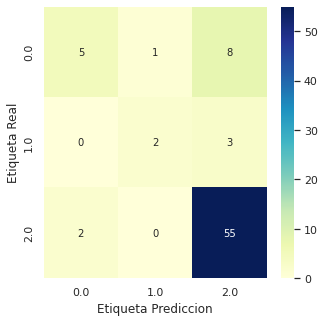

In [ ]:
data = {'y_Actual':    y_classes4,
        'y_Predicted': predict_classes4
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted']).astype(float)
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Etiqueta Real'], colnames=['Etiqueta Prediccion'])

sn.set(rc = {'figure.figsize':(5,5)})
sn.heatmap(confusion_matrix, annot=True,annot_kws={"size": 10},fmt="d", cmap="YlGnBu")
plt.show()

In [ ]:
results4 = Mod4.evaluate(test_data, test_labels)
results4

3/3 [==============================] - 0s 4ms/step - loss: 0.4550 - accuracy: 0.8816


[0.4550441801548004, 0.8815789222717285]

In [ ]:
results_val4 = Mod4.evaluate(val_data, val_labels)
results_val4

3/3 [==============================] - 0s 3ms/step - loss: 0.5464 - accuracy: 0.8267


[0.5464311242103577, 0.8266666531562805]

acertividad

In [ ]:
filtrada1 = [] # la lista filtra los que son clase=1
for i in range(len(predict_classes4)):
    if predict_classes[i] == 1:
        filtrada1.append(i)

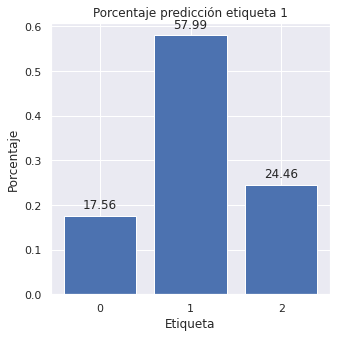

In [ ]:
# Creating histogram
fig, ax = plt.subplots(1, 1)
ax.bar(eje_x, list((statistics.mean(predict_prob4[filtrada1][:,0]),statistics.mean(predict_prob4[filtrada1][:,1]),statistics.mean(predict_prob4[filtrada1][:,2]))))
  
# Set title
ax.set_title("Porcentaje predicción etiqueta 1")
  
# adding labels
ax.set_xlabel('Etiqueta')
ax.set_ylabel('Porcentaje')
  
# Make some labels.
rects = ax.patches
labels = [round(i*100,2) for i in 
    list((statistics.mean(predict_prob4[filtrada1][:,0]),statistics.mean(predict_prob4[filtrada1][:,1]),statistics.mean(predict_prob4[filtrada1][:,2])))
]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')
  
# Show plot
plt.show()

In [ ]:
filtrada0 = [] # la lista filtra los que son clase=1
for i in range(len(predict_classes4)):
    if predict_classes[i] == 0:
        filtrada0.append(i)

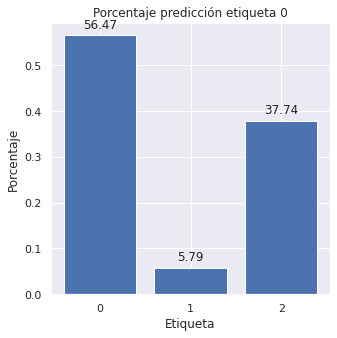

In [ ]:
# Creating histogram
fig, ax = plt.subplots(1, 1)
ax.bar(eje_x, list((statistics.mean(predict_prob4[filtrada0][:,0]),statistics.mean(predict_prob4[filtrada0][:,1]),statistics.mean(predict_prob4[filtrada0][:,2]))))
  
# Set title
ax.set_title("Porcentaje predicción etiqueta 0")
  
# adding labels
ax.set_xlabel('Etiqueta')
ax.set_ylabel('Porcentaje')
  
# Make some labels.
rects = ax.patches
labels = [round(i*100,2) for i in 
    list((statistics.mean(predict_prob4[filtrada0][:,0]),statistics.mean(predict_prob4[filtrada0][:,1]),statistics.mean(predict_prob4[filtrada0][:,2])))
]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')
  
# Show plot
plt.show()

In [ ]:
filtrada2 = [] # la lista filtra los que son clase=1
for i in range(len(predict_classes4)):
    if predict_classes[i] == 2:
        filtrada2.append(i)

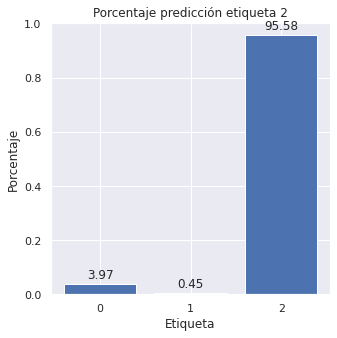

In [ ]:
# Creating histogram
fig, ax = plt.subplots(1, 1)
ax.bar(eje_x, list((statistics.mean(predict_prob4[filtrada2][:,0]),statistics.mean(predict_prob4[filtrada2][:,1]),statistics.mean(predict_prob4[filtrada2][:,2]))))
  
# Set title
ax.set_title("Porcentaje predicción etiqueta 2")
  
# adding labels
ax.set_xlabel('Etiqueta')
ax.set_ylabel('Porcentaje')
  
# Make some labels.
rects = ax.patches
labels = [round(i*100,2) for i in 
    list((statistics.mean(predict_prob4[filtrada2][:,0]),statistics.mean(predict_prob4[filtrada2][:,1]),statistics.mean(predict_prob4[filtrada2][:,2])))
]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')
  
# Show plot
plt.show()

## Opcion 5

Con 4 capas

In [ ]:
def create_network4(optimizer='rmsprop',neurons1=150, neurons2=70, neurons3=40, neurons4=16,epochs=75, batch_size=68,
                     learn_rate=0.01,  dropout_rate=0.0, activation1='relu',activation2='sigmoid',activation3='tanh',activation4='relu'):
    model = Sequential()
    model.add(Dense(neurons1,
                    input_shape=(197,),
                    activation=activation1,
                    kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(neurons2, activation=activation2))
    model.add(Dense(neurons3, activation=activation3))
    model.add(Dense(neurons4, activation=activation4))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss = 'categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])           
    
    return model

In [ ]:
# Implementación de la API del clasificador scikit-learn para Keras.
neural_network4 = KerasClassifier(build_fn=create_network4, verbose=1) ### para busqueda en grilla clasificacion

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
kfold = KFold(n_splits=4, random_state=None)

grid_param = {
    'neurons4': [6,8,10,14,20,28,30,35,38],
    'activation4' : ['relu','sigmoid','tanh']

    
}


scoring = ['accuracy'] #, 'recall'

#kfold = KFold(n_splits=4, random_state=None)

tiempo_inicial = time() 

gs5 = GridSearchCV(neural_network4,
                  param_grid=grid_param,
                  cv=kfold,
                  n_jobs=-1,
                  verbose=2)
gs5.fit(train_data, train_labels)
tiempo_final = time() 


results = gs5.cv_results_
print("\n Mejor desempeño: ", gs5.best_score_)
print("\n Mejores hiper parámetros:\n",gs5.best_params_)

tiempo_ejecucion = tiempo_final - tiempo_inicial
print('\nEl tiempo, en min, de ejecucion fue:%s'% str(tiempo_ejecucion/60))


df = pd.DataFrame(results)
df.head()

Fitting 4 folds for each of 27 candidates, totalling 108 fits
11/11 [==============================] - 1s 2ms/step - loss: 2.5162 - accuracy: 0.3314

 Mejor desempeño:  0.42940177023410797

 Mejores hiper parámetros:
 {'activation4': 'sigmoid', 'neurons4': 6}

El tiempo, en min, de ejecucion fue:1.5534807403882345


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation4,param_neurons4,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,1.828936,0.464599,0.315470,0.003509,relu,6,"{'activation4': 'relu', 'neurons4': 6}",0.238636,0.306818,0.310345,0.045977,0.225444,0.107485,16
1,1.299634,0.023978,0.295556,0.016139,relu,8,"{'activation4': 'relu', 'neurons4': 8}",0.397727,0.306818,0.471264,0.045977,0.305447,0.160731,4
2,1.314496,0.032407,0.302721,0.006456,relu,10,"{'activation4': 'relu', 'neurons4': 10}",0.238636,0.306818,0.310345,0.045977,0.225444,0.107485,16
3,1.512434,0.209971,0.314386,0.009970,relu,14,"{'activation4': 'relu', 'neurons4': 14}",0.238636,0.352273,0.310345,0.045977,0.236808,0.117430,12
4,1.300843,0.023201,0.293103,0.005640,relu,20,"{'activation4': 'relu', 'neurons4': 20}",0.238636,0.306818,0.310345,0.045977,0.225444,0.107485,16


In [ ]:
b_hp5=gs5.best_params_;b_hp5

{'activation4': 'sigmoid', 'neurons4': 6}

In [ ]:
Mod5 = create_network4(**b_hp5)

history5 = Mod5.fit(train_data, train_labels,epochs=75,verbose=0)

print(Mod5)

In [ ]:
# Obteniendo prediciones
predict_prob5 = Mod5.predict(test_data)
predict_classes5=np.argmax(predict_prob5,axis=1)
y_classes5 = [np.argmax(y, axis=None, out=None) for y in test_labels]

print("Etiquetas reales\n",y_classes5)
print("\nEtiquetas predichas\n",predict_classes5)
print("\nAcerto el modelo? \n",['Si' if e==1 else 'No' for e in list(predict_classes5==y_classes5)])

Etiquetas reales
 [2, 2, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 0, 0, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2]

Etiquetas predichas
 [1 2 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 2 0 0 2 0 1 2 2 2 2 2 1 1 0 2 2 2
 2 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 1 2 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 2 2]

Acerto el modelo? 
 ['No', 'Si', 'Si', 'No', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'No', 'No', 'Si', 'Si', 'Si', 'No', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'No', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'No', 'Si', 'Si']


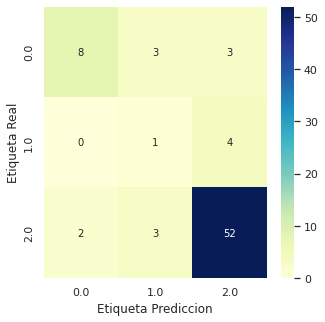

In [ ]:
data = {'y_Actual':    y_classes5,
        'y_Predicted': predict_classes5
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted']).astype(float)
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Etiqueta Real'], colnames=['Etiqueta Prediccion'])

sn.set(rc = {'figure.figsize':(5,5)})
sn.heatmap(confusion_matrix, annot=True,annot_kws={"size": 10},fmt="d", cmap="YlGnBu")
plt.show()

In [ ]:
results5 = Mod5.evaluate(test_data, test_labels)
print(results5)
results_val5 = Mod5.evaluate(val_data, val_labels)
print(results_val5)

3/3 [==============================] - 0s 8ms/step - loss: 0.6543 - accuracy: 0.8026
[0.6542995572090149, 0.8026315569877625]
3/3 [==============================] - 0s 6ms/step - loss: 0.8081 - accuracy: 0.7867
[0.8080511093139648, 0.7866666913032532]


In [ ]:
filtrada0 = [] # la lista filtra los que son clase=1
for i in range(len(predict_classes5)):
    if predict_classes5[i] == 0:
        filtrada0.append(i)

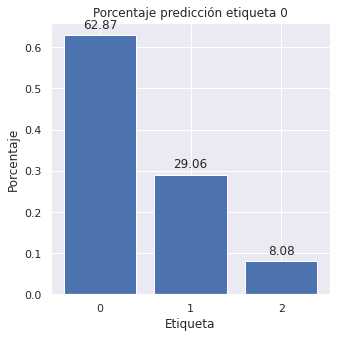

In [ ]:
# Creating histogram
fig, ax = plt.subplots(1, 1)
ax.bar(eje_x, list((statistics.mean(predict_prob5[filtrada0][:,0]),statistics.mean(predict_prob5[filtrada0][:,1]),statistics.mean(predict_prob5[filtrada0][:,2]))))
  
# Set title
ax.set_title("Porcentaje predicción etiqueta 0")
  
# adding labels
ax.set_xlabel('Etiqueta')
ax.set_ylabel('Porcentaje')
  
# Make some labels.
rects = ax.patches
labels = [round(i*100,2) for i in 
    list((statistics.mean(predict_prob5[filtrada0][:,0]),statistics.mean(predict_prob5[filtrada0][:,1]),statistics.mean(predict_prob5[filtrada0][:,2])))
]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')
  
# Show plot

In [ ]:
filtrada1 = [] # la lista filtra los que son clase=1
for i in range(len(predict_classes5)):
    if predict_classes5[i] == 1:
        filtrada1.append(i)

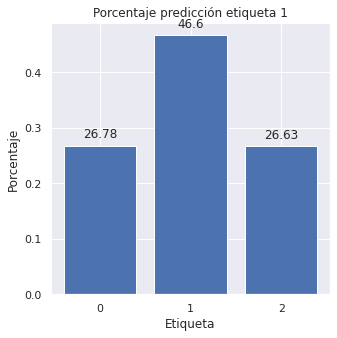

In [ ]:
# Creating histogram
fig, ax = plt.subplots(1, 1)
ax.bar(eje_x, list((statistics.mean(predict_prob5[filtrada1][:,0]),statistics.mean(predict_prob5[filtrada1][:,1]),statistics.mean(predict_prob5[filtrada1][:,2]))))
  
# Set title
ax.set_title("Porcentaje predicción etiqueta 1")
  
# adding labels
ax.set_xlabel('Etiqueta')
ax.set_ylabel('Porcentaje')
  
# Make some labels.
rects = ax.patches
labels = [round(i*100,2) for i in 
    list((statistics.mean(predict_prob5[filtrada1][:,0]),statistics.mean(predict_prob5[filtrada1][:,1]),statistics.mean(predict_prob5[filtrada1][:,2])))
]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')
  
# Show plot

In [ ]:
filtrada2 = [] # la lista filtra los que son clase=1
for i in range(len(predict_classes5)):
    if predict_classes5[i] == 2:
        filtrada2.append(i)

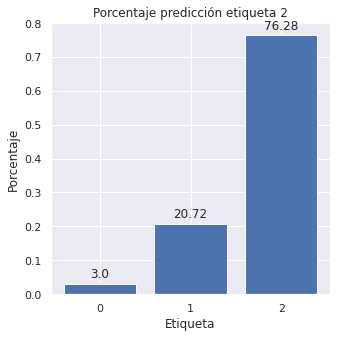

In [ ]:
# Creating histogram
fig, ax = plt.subplots(1, 1)
ax.bar(eje_x, list((statistics.mean(predict_prob5[filtrada2][:,0]),statistics.mean(predict_prob5[filtrada2][:,1]),statistics.mean(predict_prob5[filtrada2][:,2]))))
  
# Set title
ax.set_title("Porcentaje predicción etiqueta 2")
  
# adding labels
ax.set_xlabel('Etiqueta')
ax.set_ylabel('Porcentaje')
  
# Make some labels.
rects = ax.patches
labels = [round(i*100,2) for i in 
    list((statistics.mean(predict_prob5[filtrada2][:,0]),statistics.mean(predict_prob5[filtrada2][:,1]),statistics.mean(predict_prob5[filtrada2][:,2])))
]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')
  
# Show plot